### Task 10: Add Constant Product Trading interest rate as continuous rebase
* https://cryptorating.eu/whitepapers/Aave/aave-v2-whitepaper.pdf

In [1]:
import os
import copy
import numpy as np
import time
import matplotlib.pyplot as plt
cwd =  os.getcwd().replace("notebooks/test","")
os.chdir(cwd)

from python.dev.event.state.series import StateSeries
from python.dev.event.state import State
from python.dev.event import Deposit
from python.dev.event import Withdraw
from python.dev.token.trade import Convert
from python.dev.cpt import Liquidity
from python.dev.cpt import PriceCurve
from python.dev.cpt import ConstantProductTrade
from python.dev.plot import PlotPriceCurve
from python.dev.token import RebaseToken
from python.dev.math.model import TimeDeltaModel
from python.dev.math.model import TokenDeltaModel
from python.dev.math.model import EventSelectionModel

In [2]:
time0 = time.time()

In [3]:
APY = 0.1
state = State(Deposit(0,0,0))
state.init_first_state(time0)
state_series = StateSeries()

for k in range(320):
    delta = TokenDeltaModel(1,10).apply()  
    select = EventSelectionModel().bi_select(0.7)
    t_delta = TimeDeltaModel().apply()
      
    if(select == EventSelectionModel().FIRST): 
        event = Deposit(APY,delta,t_delta)
    else:
        event = Withdraw(APY,delta,t_delta)  

    state.update_event(event)
    state_series.add_state(state)
    

principle = state_series.get_principle() 
balance = state_series.get_balance() 
tSamp = state_series.get_tstamp()

In [4]:
for k in range(10):
    type_event = state_series.get_state(k).get_event().type_of()
    print('{}: {} @ {}'.format(k, type_event, tSamp[k]))

0: DEPOSIT @ 2022-05-28 21:20:04.829548
1: DEPOSIT @ 2022-05-29 16:33:32.829548
2: WITHDRAW @ 2022-05-30 06:00:00.829548
3: DEPOSIT @ 2022-05-30 14:56:41.829548
4: DEPOSIT @ 2022-06-01 04:52:16.829548
5: WITHDRAW @ 2022-06-01 06:21:32.829548
6: DEPOSIT @ 2022-06-01 15:43:58.829548
7: DEPOSIT @ 2022-06-01 16:14:48.829548
8: DEPOSIT @ 2022-06-02 06:36:53.829548
9: DEPOSIT @ 2022-06-05 14:01:05.829548


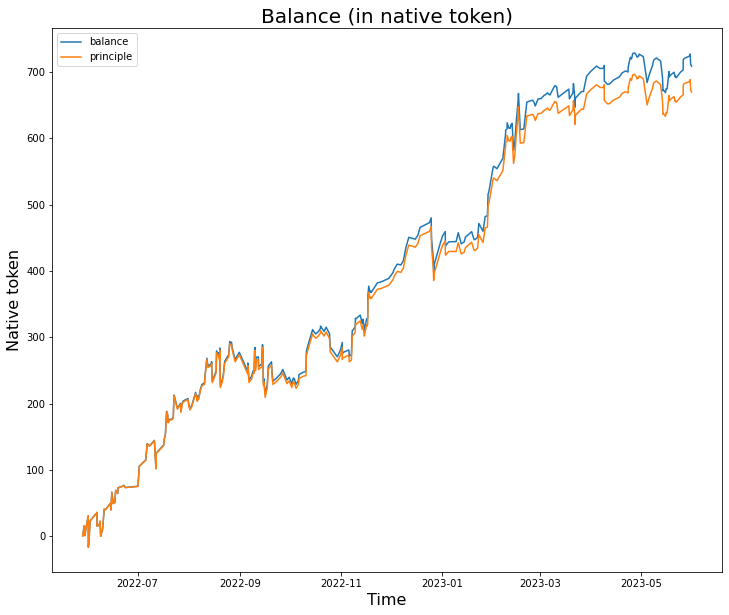

In [5]:
import matplotlib.pyplot as plt

fig, (balance_ax) = plt.subplots(nrows=1, sharex=True, sharey=False, figsize=(12, 10))

balance_ax.plot(tSamp, balance, label='balance') 
balance_ax.plot(tSamp, principle, label='principle') 

balance_ax.set_title("Balance (in native token)", fontsize=20)
balance_ax.set_ylabel("Native token", fontsize=16)
balance_ax.set_xlabel('Time', fontsize=16)
balance_ax.legend()


In [6]:
# Initialize Test Tokens

TYPE_DEPOSIT_TOKEN = 'DEPOSIT'
TYPE_DEBT_TOKEN = 'DEBT'

t_delta = TimeDeltaModel().apply()
depositT1 = TokenDeltaModel(2,20000).apply() 

T1 = RebaseToken(TYPE_DEPOSIT_TOKEN)
t1Address = T1.mint(depositT1, APY)


t_delta = TimeDeltaModel().apply()
depositTDT = TokenDeltaModel(2,20000).apply() 

TDT = RebaseToken(TYPE_DEBT_TOKEN)
tdtAddress = TDT.mint(depositT1, APY)

x = T1.get_balance_deposits()
y = TDT.get_balance_deposits()

print('[Initial] T1: {:.2f} TDT: {:.2f}\n'.format(x,y))

[Initial] T1: 5581.80 TDT: 5581.80



In [7]:
# Initialize Liquidity Pool
liq = Liquidity(x,y)
L = liq.calc(); #p = np.random.normal(5,0.1,1)[0]
p = liq.get_swap_price()
cpt = ConstantProductTrade(L)
pCurve = PriceCurve(L)

[Trade 0] T1: 5583.59647 TDT: 5581.37843 L: 5582.48745
[Trade 0] T1_prin: 5582.91059 T1_balance: 5583.59647
[Trade 0] TDT_prin: 5580.69254 TDT_balance: 5581.37843

[Trade 50] T1: 5931.04484 TDT: 5437.58561 L: 5684.82409
[Trade 50] T1_prin: 5832.43696 T1_balance: 5931.04484
[Trade 50] TDT_prin: 5331.16617 TDT_balance: 5437.58561

[Trade 100] T1: 5719.50897 TDT: 5844.43247 L: 5783.30477
[Trade 100] T1_prin: 5516.82123 T1_balance: 5719.50897
[Trade 100] TDT_prin: 5646.78190 TDT_balance: 5844.43247

[Trade 150] T1: 3666.00895 TDT: 8115.41294 L: 5904.15418
[Trade 150] T1_prin: 3386.58259 T1_balance: 3666.00895
[Trade 150] TDT_prin: 7777.02055 TDT_balance: 8115.41294

[Trade 200] T1: 2732.44208 TDT: 9208.30815 L: 6007.08517
[Trade 200] T1_prin: 2413.94320 T1_balance: 2732.44208
[Trade 200] TDT_prin: 8749.65993 TDT_balance: 9208.30815



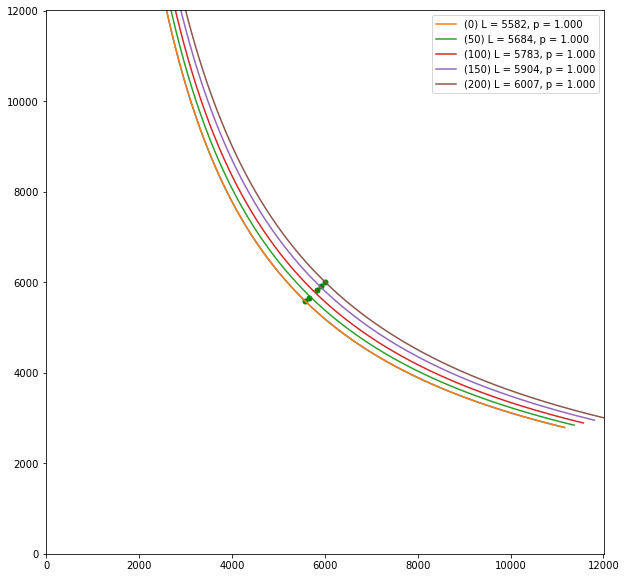

In [8]:
# Plot and execute N trades
percent = 0.05
N = 250

plotCurve = PlotPriceCurve(L, cpt, pCurve)
plotCurve.apply(p, None)

for k in range(N):
    # Generate random delta denomenated in Native token, 
    # rebalance respective accounts and convert to T1
    delta_x = TokenDeltaModel(1,100).apply() 
    t_delta = TimeDeltaModel().apply()

    select = EventSelectionModel().bi_select(0.5)
    if(select == EventSelectionModel().FIRST): 
        T1.add_event(Withdraw(APY, delta_x, t_delta, t1Address))
        TDT.add_event(Deposit(APY, delta_x, t_delta, tdtAddress)) 
    else:            
        T1.add_event(Deposit(APY, delta_x, t_delta, t1Address))
        TDT.add_event(Withdraw(APY, delta_x, t_delta, tdtAddress))
        delta_x = -delta_x
    
    TDT_yield = TDT.get_state_series(tdtAddress).get_state(k).get_yield()
    T1_yield = T1.get_state_series(t1Address).get_state(k).get_yield()
    
    liq.delta_y(TDT_yield)
    liq.delta_x(T1_yield) 
    
    x = T1.get_balance_deposits()
    y = TDT.get_balance_deposits()    
    
    L = liq.swap(delta_x); # p = np.random.normal(5,0.1,1)[0]
    p = liq.get_swap_price()
    if (k % int(N/(100*percent)) == 0):
        plotCurve.apply_next(p, L, '({}) L = {}, p = {:.3f}'.format(k, int(L),p))
        plotCurve.plot_trade(p, delta_x, 'r--')
        T1_prin = T1.get_state_series(t1Address).get_state(k).get_principle()
        T1_balance = T1.get_state_series(t1Address).get_state(k).get_balance()

        TDT_prin = TDT.get_state_series(tdtAddress).get_state(k).get_principle()
        TDT_balance = TDT.get_state_series(tdtAddress).get_state(k).get_balance()
            
        print('[Trade {}] T1: {:.5f} TDT: {:.5f} L: {:.5f}'.format(k, x,y,L))
        print('[Trade {}] T1_prin: {:.5f} T1_balance: {:.5f}'.format(k, T1_prin,T1_balance))
        print('[Trade {}] TDT_prin: {:.5f} TDT_balance: {:.5f}\n'.format(k, TDT_prin,TDT_balance))
      




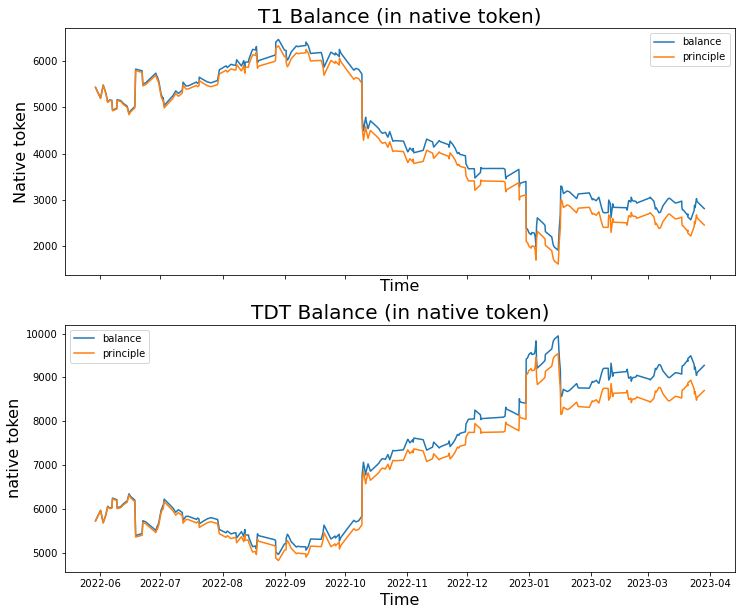

In [9]:
# Analyze Token balances

T1_states = T1.get_state_series(t1Address)
principle = T1_states.get_principle() 
balance = T1_states.get_balance() 
tSamp = T1_states.get_tstamp()  

fig, (T1_ax, TDT_ax) = plt.subplots(nrows=2, sharex=True, sharey=False, figsize=(12, 10))

T1_ax.plot(tSamp[1:], balance[1:], label='balance') 
T1_ax.plot(tSamp[1:], principle[1:], label='principle') 
T1_ax.set_title("T1 Balance (in native token)", fontsize=20)
T1_ax.set_ylabel("Native token", fontsize=16)
T1_ax.set_xlabel('Time', fontsize=16)
T1_ax.legend()

TDT_states = TDT.get_state_series(tdtAddress)
principle = TDT_states.get_principle() 
balance = TDT_states.get_balance() 
tSamp = TDT_states.get_tstamp() 

TDT_ax.plot(tSamp[1:], balance[1:], label='balance') 
TDT_ax.plot(tSamp[1:], principle[1:], label='principle') 
TDT_ax.set_title("TDT Balance (in native token)", fontsize=20)
TDT_ax.set_ylabel("native token", fontsize=16)
TDT_ax.set_xlabel('Time', fontsize=16)
TDT_ax.legend()
